# Assignment 1  

For the exercises below you can use the numpy and scipy libraries.

### Problem 3: Stochastic Gradient Descent (30 points)

In class we covered the baseline stochastic gradient descent.  Using the linear regression example from the class notes, develop from scratch the baseline SGD algorithm. :

Clearly state the hyperparameters you used and present the loss vs epoch plot that demonstrates the convergence of the algorithm.

### Import libraries

In [1]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml

  Cloning https://github.com/pantelis-classes/PRML.git to c:\users\thaou\appdata\local\temp\pip-install-v4a3t9gp\prml_967cad026f9a4dc1943e0c62915dba39
  Resolved https://github.com/pantelis-classes/PRML.git to commit 14cf88538d2704fd18b391ae6309fb38c65a6412
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for prml: filename=prml-0.0.1-py3-none-any.whl size=89281 sha256=b03cbdd6e93870f4d262cacb0018a86ed561fe1ec1dd9880fa226b5def62d1e5
  Stored in directory: C:\Users\thaou\AppData\Local\Temp\pip-ephem-wheel-cache-k0nnqqmt\wheels\b0\04\4d\c83023a0d9c4b6bd4abd20cc12a4893c28a72967bf23eb4175
Successfully built prml


  Running command git clone --filter=blob:none --quiet https://github.com/pantelis-classes/PRML.git 'C:\Users\thaou\AppData\Local\Temp\pip-install-v4a3t9gp\prml_967cad026f9a4dc1943e0c62915dba39'

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)
import seaborn as sns

# Apply the default theme
sns.set_theme()

### The linear regression example from the class notes:

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
C:\Users\thaou\AppData\Local\Temp\ipykernel_23756\422512308.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_test, y_test, color="black", linestyle="--", label="Target Function $\sin(2\pi x)$")


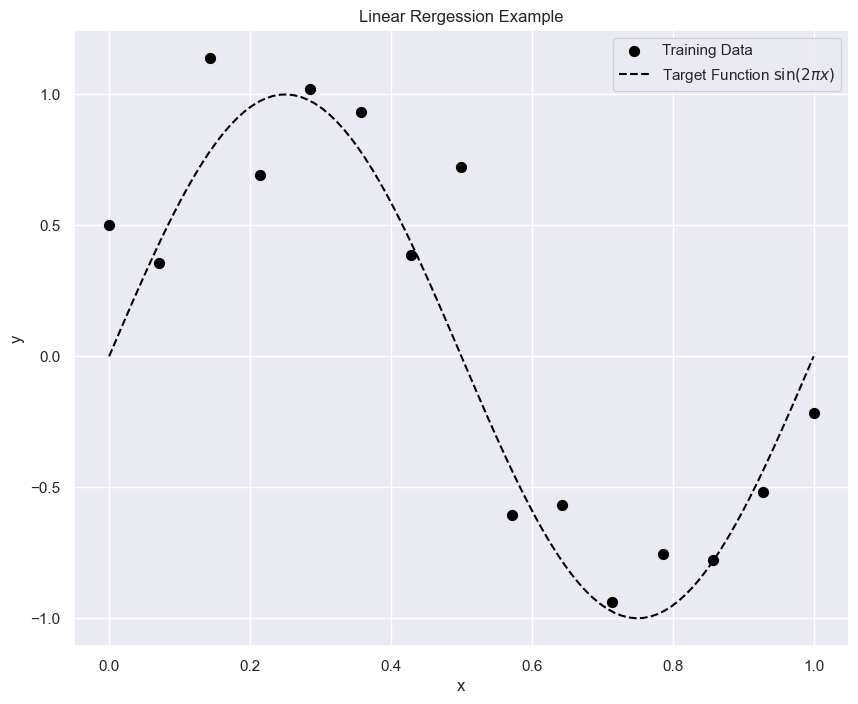

In [2]:
np.random.seed(1234)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 15, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[10,8])
plt.title('Linear Rergession Example'); plt.xlabel('x'); plt.ylabel('y')
plt.scatter(x_train, y_train, color="black", s=50, label="Training Data")
plt.plot(x_test, y_test, color="black", linestyle="--", label="Target Function $\sin(2\pi x)$")
plt.legend()
plt.show()

### Baseline SGD

In this section, 
* create_polynomial_features(): is to create $x$, $x^1$,...$x^m$ to allow my polynomial_sdg() function to be flexible with any input regression degree.
* learning_schedule(): to define the learning rate in which $t_0$ and $t_1$ are hyperparameters, $t$ is the current iteration or time step during training. As $t$ increases, the learning rate decreases so that the model to take larger steps in the beginning and gradually decrease the step size as the optimization process converges.
* mse(): calculation method that follows the formula $MSE$ = $\frac{1}{n}$ $\sum(y_{true} - y_{pred})^2$
* polynomial_sgd():
    * np.random.seed(1234): to reproduce the same number of generator every time.
    * X_poly = create_polynomial_features(X, degree): Creates polynomial features from the input data.
    * X_bias = np.c_[np.ones((m, 1)), X_poly]: Adds a bias term $(= 1)$ to the polynomial features matrix.
    * theta = np.random.randn(degree + 1, 1): Initializes model parameters randomly.
    * The main training loop:
        * Randomly selects a training example.
        * Computes gradients and updates parameters using the learning schedule and SGD.
        * Appends the current parameters to theta_store_sgd.
        * Computes the predictions and calculates the MSE (loss) for the entire dataset.
        * Appends the loss to loss_store.
    * Returns the lists of parameter paths (theta_store_sgd) and loss values (loss_store) for analysis and visualization.


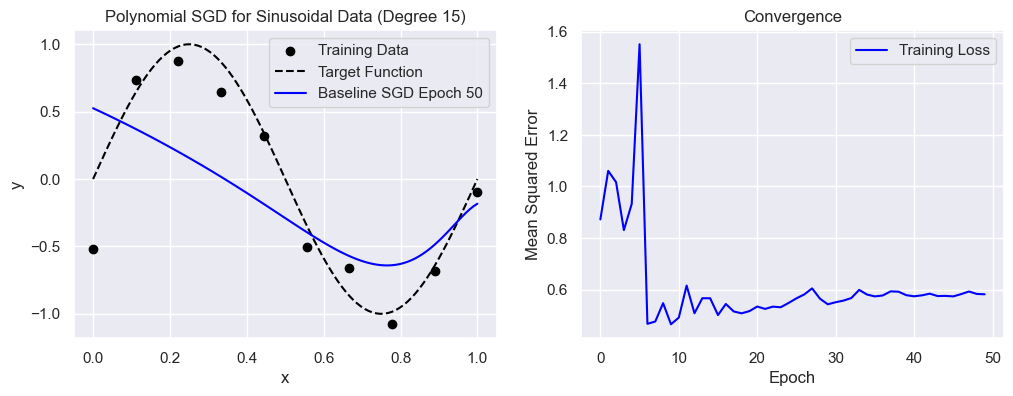

In [27]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

def create_polynomial_features(X, degree):
    X_poly = np.c_[X]
    for i in range(2, degree + 1):
        X_poly = np.c_[X_poly, X ** i]
    return X_poly

def learning_schedule(t):
    t0, t1 = 5, 50
    return t0 / (t + t1)

def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def polynomial_sgd(X, y, degree, n_epochs=50):
    m = len(X)
    theta_store_sgd = []
    loss_store = []
    np.random.seed(42)
    
    X_poly = create_polynomial_features(X, degree)
    X_bias = np.c_[np.ones((m, 1)), X_poly]
    theta = np.random.randn(degree + 1, 1)

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_bias[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradients
            theta_store_sgd.append(theta.copy())

        y_pred = X_bias.dot(theta)
        loss = mse(y, y_pred)
        loss_store.append(loss)

    return theta_store_sgd, loss_path

# Create sinusoidal toy data
np.random.seed(1234)
x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# Apply SGD to the sinusoidal data
degree = 15
theta_path_sgd, loss_path = polynomial_sgd(x_train, y_train, degree)

# Predict
X_poly_test = create_polynomial_features(x_test, degree)
y_predict = np.c_[np.ones((len(x_test), 1)), X_poly_test].dot(theta_path_sgd[499])
# Plot the true function

# Plot the all polynomial predictions during training
# for i in range(0, len(theta_path_sgd), 10):
#     X_poly_test = polynomial_features(x_test, degree)
#     y_predict = np.c_[np.ones((len(x_test), 1)), X_poly_test].dot(theta_path_sgd[i])
#     plt.plot(x_test, y_predict, label=f'Epoch {i//10}', linestyle='--')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(f'Polynomial SGD for Sinusoidal Data (Degree {degree})')
plt.xlabel('x'); plt.ylabel('y')
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.plot(x_test, y_test, color='black', linestyle='--', label='Target Function')
plt.plot(x_test, y_predict, color='blue', label='Baseline SGD Epoch 50')
plt.legend()


# Plot loss vs epoch
plt.subplot(1, 2, 2)
plt.plot(loss_path, label='Training Loss', color='blue')
plt.title('Convergence'); plt.xlabel('Epoch'); plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


### Problem 4: SGD Enhancements (30 points)

In this exercise you will implement some enhancements for the linear regression problem from scratch that can improve the convergence speed of the algorithm.

1. Momentum (15 points)
2. Adam (15 points)

Clearly state the hyperparameters you used and present the loss vs epoch plot that demonstrates the convergence of each algorithm and compared to the baseline SGD algorithm. You can include all plots in the same figure.

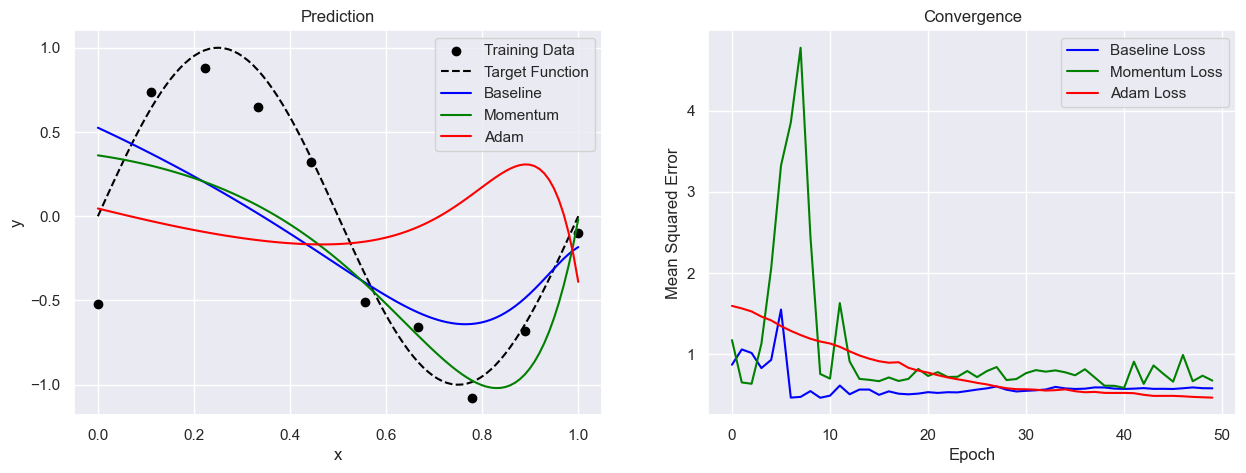

In [28]:
def advanced_polynomial_sgd(X, y, degree, optimizer='sgd', learning_rate=0.01, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, n_epochs=50):
    m = len(X)
    theta_store = []
    loss_store = []
    np.random.seed(42)
    
    X_poly = create_polynomial_features(X, degree)
    X_bias = np.c_[np.ones((m, 1)), X_poly]
    theta = np.random.randn(degree + 1, 1)
    v = np.zeros_like(theta)  # For momentum
    m_t = np.zeros_like(theta)  # For Adam
    v_t = np.zeros_like(theta)  # For Adam
    t = 0  # For Adam

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_bias[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            
            if optimizer == 'sgd':
                eta = learning_schedule(epoch * m + i)
                theta = theta - eta * gradients
            elif optimizer == 'momentum':
                eta = learning_schedule(epoch * m + i)
                v = momentum * v + learning_rate * gradients
                theta = theta - v
            elif optimizer == 'adam':
                t += 1
                eta = learning_rate * np.sqrt(1 - beta2**t) / (1 - beta1**t)
                m_t = beta1 * m_t + (1 - beta1) * gradients
                v_t = beta2 * v_t + (1 - beta2) * gradients**2
                m_t_hat = m_t / (1 - beta1**t)
                v_t_hat = v_t / (1 - beta2**t)
                theta = theta - eta * m_t_hat / (np.sqrt(v_t_hat) + epsilon)
            
            theta_store.append(theta.copy())

        y_pred = X_bias.dot(theta)
        loss = mse(y, y_pred)
        loss_store.append(loss)

    return theta_store, loss_store

# Create sinusoidal toy data
np.random.seed(1234)
x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)
degree = 15

# Apply Polynomial SGD to the sinusoidal data
theta_store_sgd, loss_store_sgd = advanced_polynomial_sgd(x_train, y_train, degree, optimizer='sgd')
theta_store_momentum, loss_store_momentum = advanced_polynomial_sgd(x_train, y_train, degree, optimizer='momentum')
theta_store_adam, loss_store_adam = advanced_polynomial_sgd(x_train, y_train, degree, optimizer='adam')

# Plot target function, baseline, momentum, adam sgd
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1); 
plt.title('Prediction'); plt.xlabel('x'); plt.ylabel('y')
plt.scatter(x_train, y_train, color='black', label='Training Data')
plt.plot(x_test, y_test, color="black", linestyle="--", label="Target Function")
plt.plot(x_test, np.c_[np.ones((len(x_test), 1)), create_polynomial_features(x_test, degree)].dot(theta_store_sgd[-1]), label='Baseline', color='blue')
plt.plot(x_test, np.c_[np.ones((len(x_test), 1)), create_polynomial_features(x_test, degree)].dot(theta_store_momentum[-1]), label='Momentum', color='green')
plt.plot(x_test, np.c_[np.ones((len(x_test), 1)), create_polynomial_features(x_test, degree)].dot(theta_store_adam[-1]), label='Adam', color='red')
plt.legend()

# Plot loss vs epoch
plt.subplot(1, 2, 2)
plt.title('Convergence'); plt.xlabel('Epoch'); plt.ylabel('Mean Squared Error')
plt.plot(loss_store_sgd, label='Baseline Loss', color='blue')
plt.plot(loss_store_momentum, label='Momentum Loss', color='green')
plt.plot(loss_store_adam, label='Adam Loss', color='red')
plt.legend()

The hyperparameters in this model:
* learning_rate $\eta$ = 0.01
* momentum $V_{t}$ = 0.9
* $\beta_{1}$ = 0.9
* $\beta_{2}$ = 0.999
* $\epsilon$ = 1e-8
* n_epochs = 50
* degree = 15

### MOMENTUM OPTIMIZER
The change in the weights is denoted by the formula:
$$
V_{t} = \beta V_{t-1}+ \eta W_{t}
$$
Source: <a href="https://paperswithcode.com/method/sgd-with-momentum">Papers With Code</a>
### ADAM OPTIMIZER
In Adam optimization algorithm, $m_{t}$ and $v_{t}$ are vectors used for estimating the first and second moments (mean and uncentered variance) of the gradients during the training process. 

The formula used in this code for Adam optimizer is from
<a href="https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb">Medium</a>.

We first compute the decaying average of past squared gradients and past gradients as the following formula:
$$
m_{t} = \beta_{1}m_{t-1}+(1-\beta_{1})g_{t} 
$$

$$\beta_{2}
v_{t} = v_{t-1}+(1-\beta_{2})g_{t}^2
$$ 

where $m$ is the decaying average of past gradients $g_{t}$ and $v$ is the decaying average of past squared gradients $g_{t}^2$.

Initially $m$ and $v$ are started with 0 vectors and as the decay rates are small enough in the beginning where (both the betas are close to 1), we see that both these are biased towards 0.

Thus we work on these biases by computing bias-corrected terms:

$$
\hat{m_{t}} = \frac{m_{t}}{1-\beta_{1}^t}\
$$
$$
\hat{v_{t}} = \frac{v_{t}}{1-\beta_{2}^t}\
$$

And finally we update the parameters similar to the previous optimization technique:
$$
\theta_{t} = \theta_{t-1}-\frac{\eta}{\sqrt{\hat{v_{t}}+\epsilon}}\hat{m_{t}}
$$
